<a href="https://colab.research.google.com/github/VMM-MMV/SigmoidExam/blob/main/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip install pandas-profiling
!pip install seaborn
!pip install fancyimpute

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os, math
import pandas_profiling
from fancyimpute import IterativeImputer, KNN
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


In [65]:
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

%cd /content/gdrive/My Drive/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


Importing and showcasing data set.

In [66]:
df = pd.read_csv("data.csv")
df

Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16714  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16715               LMA Manager 2007     X360           2006.0        Sports   
16716        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16717               Spirits & Spells      GBA           2003.0      Platform   
16718            Winning Post 8 2016      PSV           2016.0    Simulation   

          Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  \
0          Nintendo     41.36     28.96      3.77         8.45         82.53   
1          Nintendo     29.08      3.58      6.81         0.77         40.24   
2          Nintendo     15.68     12.76      3.79         3.29         35.52   
3          Nintendo     15.61     10.93      3.28         2.95         32.77   
4          Nintendo     11.27      8.89     10.22         1.00         31.37   
...             ...       ...       ...       ...          ...           ...   
16714    Tecmo Koei      0.00      0.00      0.01         0.00          0.01   
16715   Codemasters      0.00      0.01      0.00         0.00          0.01   
16716  Idea Factory      0.00      0.00      0.01         0.00          0.01   
16717       Wanadoo      0.01      0.00      0.00         0.00          0.01   
16718    Tecmo Koei      0.00      0.00      0.01         0.00          0.01   

       Critic_Score  Critic_Count User_Score  User_Count Developer Rating  
0              76.0          51.0          8       322.0  Nintendo      E  
1               NaN           NaN        NaN         NaN       NaN    NaN  
2              82.0          73.0        8.3       709.0  Nintendo      E  
3              80.0          73.0          8       192.0  Nintendo      E  
4               NaN           NaN        NaN         NaN       NaN    NaN  
...             ...           ...        ...         ...       ...    ...  
16714           NaN           NaN        NaN         NaN       NaN    NaN  
16715           NaN           NaN        NaN         NaN       NaN    NaN  
16716           NaN           NaN        NaN         NaN       NaN    NaN  
16717           NaN           NaN        NaN         NaN       NaN    NaN  
16718           NaN           NaN        NaN         NaN       NaN    NaN  

[16719 rows x 16 columns]

#Cleaning

Checking For Dublicates

In [67]:
df.duplicated().sum()

0

We have no dublicates

# Replace NAN values

Here I use a library that generates df reports.

In [68]:
profile = pandas_profiling.ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the above report we can conclude

> Indented block


  1. Year_of_Release is highly correlated with Platform, which makes sense.
  2. Sales only have high correlations between eachother.
  3. Scores and Counts only have high correlations between eachother.
  4. Year_of_Release has the pattern for a normal distribution.
  5. Sales have a lot of zeros.
  6. Critic score follows a normal distribution, with most values around 70.
  7. Critic Count follows a exponential distribution.
  8. User Scores, have value 'tbd'(to be decided?), that when replaced with nan, shows the same normal distribution as critic score, but no closer to around 80.
  9. User Count follows a exponential distribution as well, but with a very heavy emphasis on the first values.

Replacing tbd with nan.

In [69]:
df['User_Score'] = df['User_Score'].replace('tbd', np.nan)

There are also some problems with the Publisher column since some NaN's are represented with "Unknown" instead.

It has only 50 nans.

In [70]:
df["Publisher"].isna().sum()

54

But if we look for Unknown we see that Publisher is the only column that has Unknown, and there are 200 of them.

In [71]:
for i in df.columns:
    try:
      print(i, df[i].value_counts()["Unknown"])
    except:
      pass

Publisher 201


Let's unite them.

In [72]:
df["Publisher"].replace("Unknown", np.nan, inplace=True)
for i in df.columns:
    try:
      print(i, df[i].value_counts()["Unknown"])
    except:
      pass

df["Publisher"].isna().sum()

255

And we will see that it has the corect amount of nans.

In [73]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher           255
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

We can see 2 types of nans, big nans and small nans. So I thought that I might as well make some scrapers that can inpute the missing values from small nans with real life data.

Get the file of small nans.

In [74]:
missing_rows = df[df["Year_of_Release"].isna() | df["Publisher"].isna()]

missing_rows.to_csv('MissingRows.csv', index=False)

Imputing with beautiful soup from www.gamesdatabase.org:

Initial:

Name                 0
Platform             0
Year_of_Release    269
Genre                0
Publisher          255
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       215
Critic_Count       215
User_Score         175
User_Count         243
Developer          156
Rating             170

Output:

Name                 0
Platform             0
Year_of_Release    211
Genre                0
Publisher          223
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       215
Critic_Count       215
User_Score         175
User_Count         243
Developer          142
Rating             170

Imputing with igdb api:

Initial

Name                 0
Platform             0
Year_of_Release    269
Genre                0
Publisher          255
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       215
Critic_Count       215
User_Score         175
User_Count         243
Developer          156
Rating             170

Output

Name                 0
Platform             0
Year_of_Release     68
Genre                0
Publisher          130
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       215
Critic_Count       215
User_Score         175
User_Count         243
Developer          156
Rating             170
dtype: int64

Imputting with selenium from www.wikidata.org:

Initial

Name                 0
Platform             0
Year_of_Release    269
Genre                0
Publisher          255
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       215
Critic_Count       215
User_Score         175
User_Count         243
Developer          156
Rating             170

Output

Name                 0
Platform             0
Year_of_Release     58
Genre                0
Publisher          142
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       215
Critic_Count       215
User_Score         175
User_Count         243
Developer          114
Rating             170

API and bs4

Initial

Name                 0
Platform             0
Year_of_Release     68
Genre                0
Publisher          130
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       215
Critic_Count       215
User_Score         175
User_Count         243
Developer          156
Rating             170

Output

Unnamed: 0           0
Name                 0
Platform             0
Year_of_Release     58
Genre                0
Publisher          118
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       215
Critic_Count       215
User_Score         175
User_Count         243
Developer          142
Rating             170

All of them togheter

Input

Name                 0
Platform             0
Year_of_Release    269
Genre                0
Publisher          255
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       215
Critic_Count       215
User_Score         175
User_Count         243
Developer          156
Rating             170

Output

Unnamed: 0           0
Name                 0
Platform             0
Year_of_Release     25
Genre                0
Publisher           88
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       215
Critic_Count       215
User_Score         175
User_Count         243
Developer          140
Rating             170

Now let's put it back into the original data frame.

In [75]:
df_cleaned = df.dropna(subset=['Year_of_Release', 'Publisher'])

modified_df = pd.read_csv('AllReplaced.csv')

modified_df = modified_df.drop(columns=['Unnamed: 0'])
modified_df = modified_df.drop(columns=['Unnamed: 0.1'])
modified_df['User_Score'] = modified_df['User_Score'].replace('tbd', np.nan)

df_cleaned = df_cleaned.append(modified_df, ignore_index=True)

print(len(df), len(df_cleaned))
df_cleaned.isna().sum()

16719 16719


<ipython-input-75-c751d8c66bbd>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cleaned = df_cleaned.append(modified_df, ignore_index=True)


Name                  2
Platform              0
Year_of_Release       1
Genre                 2
Publisher             1
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6607
Rating             6769
dtype: int64

Very good results, with some minor nans. I think they are negligeble so I deleted them. And only 3 rows were droped.

In [76]:
df_cleaned = df_cleaned.dropna(subset=['Name', 'Year_of_Release', 'Genre', 'Publisher'])
print(len(df), len(df_cleaned))
df_cleaned.isna().sum()
df = df_cleaned

16719 16716


But still, we can see that I have a lot of big nan values. I have 2 options droping them, or imputing them. I also thought of a combination, to drop the smallest column out of the big ones, that being developer thus they would be about 1000 nans left which is more doable.

#Inputing data


Plotting the User_Score column.

<ipython-input-77-d3b547379f2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')


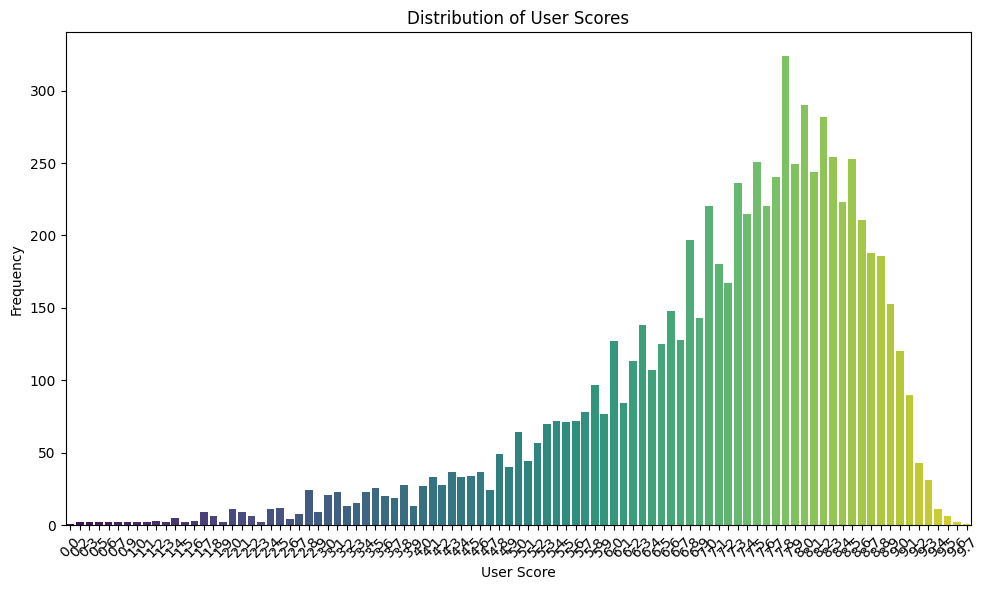

In [77]:
plt.figure(figsize=(10,6))

df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')
sns.countplot(x='User_Score', data=df, order=df['User_Score'].dropna().sort_values().unique(), palette='viridis')


plt.title('Distribution of User Scores')
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Imputing with IterativeImputer.

In [78]:
df_copy = df.copy()

imputer = IterativeImputer(max_iter=10, random_state=0)

df_copy['User_Score'] = imputer.fit_transform(df_copy[['User_Score']])


The result is shady to say the least.

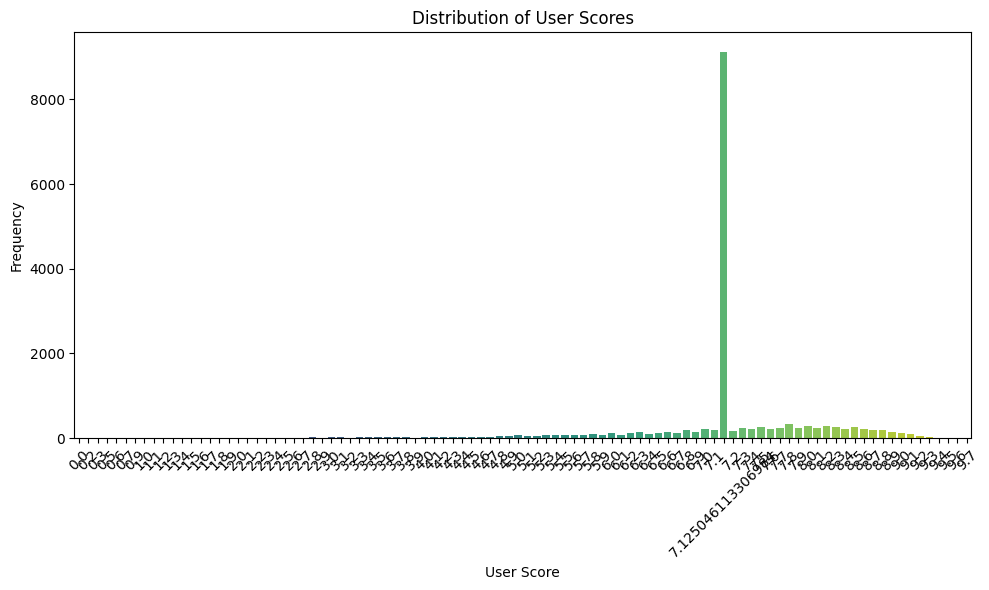

In [79]:
plt.figure(figsize=(10,6))

sns.countplot(x='User_Score', data=df_copy, order=df_copy['User_Score'].dropna().sort_values().unique(), palette='viridis')

plt.title('Distribution of User Scores')
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Making a KNN imputer.

In [ ]:
df_copy = df.copy()

df_copy['User_Score'] = pd.to_numeric(df_copy['User_Score'], errors='coerce')

k = 10
imputer = KNN(k=k)

df_copy['User_Score'] = imputer.fit_transform(df_copy[['User_Score']])

This result is even worse.

In [ ]:
plt.figure(figsize=(10,6))

df_copy2 = df.copy()

sns.countplot(x='User_Score', data=df_copy, order=df_copy2['User_Score'].dropna().sort_values().unique(), palette='viridis')

plt.title('Distribution of User Scores')
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

I guess IterativeInputer looks better.

So, from here I'm going to make 3 data frames. One where I drop everything. One where I drop the smallest big column. And one where I do IterativeInputer.

Making functions so I can use them at the end to see which combination is best.

Drop function

In [ ]:
def drop_df(df):
    df_copy = df.copy()
    df_copy = df.dropna(subset=['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'])
    return df_copy

Partial drop with the Rating column having a bit left behind so I inpute it.

In [ ]:
def partial_drop_df(df, imputer):
    df_copy = df.copy()
    df_copy.dropna(subset=['Developer'], inplace=True)

    # Frequency Encoding on rating
    rating_freq = df_copy['Rating'].value_counts(normalize=True)
    df_copy[df_copy.columns[df_copy.columns.get_loc('Rating')]] = df_copy['Rating'].map(rating_freq)

    # Imputation Columns
    columns_to_impute = ['Critic_Score', 'Critic_Count' , 'User_Score', 'User_Count', 'Rating']

    # Perform imputation one column at a time
    for column in columns_to_impute:
        df_copy.loc[:, column] = imputer.fit_transform(df_copy[[column]]);

    return df_copy


And just imputing them all.

In [ ]:
def impute_all(df, imputer):
    # Imputation Columns
    columns_to_impute = ['Critic_Score', 'Critic_Count' , 'User_Score', 'User_Count', 'Rating', 'Developer']

    # Frequency Encoding on Rating
    rating_freq = df_copy['Rating'].value_counts(normalize=True)
    df_copy[df_copy.columns[df_copy.columns.get_loc('Rating')]] = df_copy['Rating'].map(rating_freq)

    # Frequency Encoding on Developer
    rating_freq = df_copy['Developer'].value_counts(normalize=True)
    df_copy[df_copy.columns[df_copy.columns.get_loc('Developer')]] = df_copy['Developer'].map(rating_freq)

    # Perform imputation one column at a time
    for column in columns_to_impute:
        df_copy.loc[:, column] = imputer.fit_transform(df_copy[[column]]);

    return df_copy

A plotter for visualization.

In [ ]:
def subplots(df, columns_to_plot):
    # Define the number of rows and columns for the subplots
    half = int(len(columns_to_plot) / 2)
    n_cols = half
    n_rows = len(columns_to_plot) - half

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 15))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Space between the subplots

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Iterate over the columns to plot and the corresponding axis
    for i, column in enumerate(columns_to_plot):
        axs[i].hist(df[column].dropna(), bins=20, edgecolor='k', alpha=0.7)
        axs[i].set_title(column)
        axs[i].set_xlabel(column)
        axs[i].set_ylabel('Frequency')

    # Remove the extra subplots if any
    for i in range(len(columns_to_plot), n_rows * n_cols):
        fig.delaxes(axs[i])

    plt.show()


Here's a showcase of how the initial and the change df looks for partial drop.

In [ ]:
subplots(df, ['Critic_Score', 'Critic_Count' , 'User_Score', 'User_Count', 'Rating'])

In [ ]:
df_copy = partial_drop_df(df, IterativeImputer(max_iter=10, random_state=0))
df_copy.isna().sum()

In [ ]:
subplots(df_copy, ['Critic_Score', 'Critic_Count' , 'User_Score', 'User_Count', 'Rating'])

For full impute.

In [ ]:
df_copy = impute_all(df, IterativeImputer(max_iter=10, random_state=0))
df_copy.isna().sum()

In [ ]:
subplots(df_copy, ['Critic_Score', 'Critic_Count' , 'User_Score', 'User_Count', 'Rating', 'Developer'])

#Class Balancing

I thought of making class balancing since I noticed a clear inbalance in the Ratings column. But thinking about it more, first of all this is a continious dataset so this is not that big of an issue. And it did not make sense, since this is in the real life; Game developers don't useally want to box themself into a certain demografic, since the reach is bigger. Or they make only for a demografic, that will make them more money. And the distribution seem to follow that.

#Encoding

Checking for all the different types of data types.

In [ ]:
for i in df.columns:
    print(i, df[i].dtype)


Thus we can see that we have some strings, that we need to inpute.

Those being.

In [ ]:
for i in df.columns:
    if df[i].dtype == object:
        print(i)


Visualing the difference.

In [ ]:
data_types = df.dtypes

data_type_counts = data_types.value_counts()

In [ ]:
data_type_counts.plot(kind='bar')
plt.xlabel('Data Type')
plt.ylabel('Number of Columns')
plt.title('Data Types of DataFrame Columns')
plt.show()

Now let's we what kind of inputers we would need.

In [ ]:
for i in df.columns:
  if df[i].dtype == object:
    print(i, len(df[i].unique()))

We see again quite the range. Regarding name had some thought to group names into bundles, for example FIFA 14 and FIFA 15 to be FIFA. Decided to use nltk, but it takes a lot of time to go over all the combinations of names and check them, between each other. And, sometimes because of the treshold you have to set, you either don't get all the games you wanted, or you get unwanted games that are not realted at all in bundles. So I decided to drop it.
So:
lower thrselhold = false positives
bigger threshold = not all games bundled, that to a human apear to be in one category.

So let's start off by droping the names, since I can't do nothing about them and they are more of an ID.

In [ ]:
df = df.drop("Name", axis=1)

Then I'll do 2 types of encoders to see which is best: 1. frequency encoder and 2. target encoder.

In [ ]:
def frequency_encoder(df, column):
    # Calculating the frequency of each category in the column
    freq = df[column].value_counts(normalize=True)  # normalize=True gives the relative frequency

    # Replacing the original values with their corresponding frequencies
    return df[column].map(freq)

In [ ]:
def frequency_encoding(df, columns):
    df_copy = df.copy()
    for column in columns:
      df_copy[column] = frequency_encoder(df_copy, column)
    return df_copy

In [ ]:
def target_encoder(df, column, target):
    # Calculating the mean of the target variable for each category in the column
    target_means = df.groupby(column)[target].mean()

    # Replacing the original values with their corresponding target means
    return df[column].map(target_means)

In [ ]:
def target_encoding(df, columns, target):
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = target_encoder(df_copy, column, target)
    return df_copy

Plotter for visualization.

In [ ]:
def plot(df, columns, data=None):
    for column in columns:
        plt.figure(figsize=(15,8))

        # If no data is provided, use the provided DataFrame df
        if data is None:
            data_to_plot = df
        else:
            data_to_plot = data

        sns.countplot(x=column, data=data_to_plot, order=data_to_plot[column].dropna().sort_values().unique(), palette='viridis')

        plt.title('Distribution of ' + column)
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.xticks(rotation=90, fontsize=10)
        plt.tight_layout()
        plt.show()


Now let's see how they work.

Frequency Encoder

In [ ]:
plot(df, ["Platform", "Genre", "Rating"])

publishers_with_more_than_10_games = df.groupby('Publisher').filter(lambda x: len(x) > 10)
plot(df, ["Publisher"], publishers_with_more_than_10_games)

developers_with_more_than_10_games = df.groupby('Developer').filter(lambda x: len(x) > 10)
plot(df, ['Developer'], developers_with_more_than_10_games)


In [ ]:
df_copy = frequency_encoding(df, ["Platform", "Genre", "Rating", "Publisher", "Developer"])

In [ ]:
plot(df_copy, ["Platform", "Genre", "Rating"])

publishers_with_more_than_10_games = df_copy.groupby('Publisher').filter(lambda x: len(x) > 10)
plot(df_copy, ["Publisher"], publishers_with_more_than_10_games)

developers_with_more_than_10_games = df_copy.groupby('Developer').filter(lambda x: len(x) > 10)
plot(df_copy, ['Developer'], developers_with_more_than_10_games)


Target Encoder

In [ ]:
df_copy = target_encoding(df, ["Platform", "Genre", "Rating", "Publisher", "Developer"], "Global_Sales")

In [ ]:
publishers_with_more_than_10_games = df_copy.groupby('Publisher').filter(lambda x: len(x) > 10)
plot(df_copy, ["Publisher"], publishers_with_more_than_10_games)

developers_with_more_than_10_games = df_copy.groupby('Developer').filter(lambda x: len(x) > 10)
plot(df_copy, ['Developer'], developers_with_more_than_10_games)

#Outlier Detection

For outliers I decided to make 2 algorithms as well: 1. IsolationForest 2. Some algorithm I found online when the first one did not have the expected results.3

IsolationForest

In [ ]:
def detect_outliers(df):
  df_clean = df.copy()

  isolation_forest = IsolationForest(contamination=0.4)

  df_clean["outlier"] = pd.Series(isolation_forest.fit_predict(df_clean.values))
  df_clean = df_clean[df_clean.outlier!=-1]
  df_clean.drop("outlier",axis=1,inplace=True)
  return df_clean

Random Algo

In [ ]:
def rm_outliers(df, list_of_keys):
    df_out = df.copy()
    removed = pd.DataFrame()

    for key in list_of_keys:
        # Calculate first and third quartiles using quantile function
        first_quartile = df_out[key].quantile(0.25)
        third_quartile = df_out[key].quantile(0.75)

        # Interquartile range
        iqr = third_quartile - first_quartile

        # Remove outliers
        outliers = df_out[(df_out[key] < (first_quartile - 3 * iqr)) |
                           (df_out[key] > (third_quartile + 3 * iqr))]
        removed = pd.concat([removed, outliers])  # Append outliers to the removed DataFrame
        df_out = df_out[(df_out[key] >= (first_quartile - 3 * iqr)) &
                        (df_out[key] <= (third_quartile + 3 * iqr))]

    return df_out

Outlier Plotter

In [ ]:
def plot_outliers(df, exclude_columns = None):
    if exclude_columns is None:
        exclude_columns = ['Global_Sales', 'Other_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales']

    # Selecting numeric columns other than the specified ones
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    plot_columns = [col for col in numeric_cols if col not in exclude_columns]

    # Plotting box plots for the selected columns
    for col in plot_columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[col])
        plt.title(f'Box plot of {col}')
        plt.show()


Encoding so we can visualize outliers in the columns that are not numbers.

In [ ]:
df_outliers = frequency_encoding(drop_df(df),["Platform","Genre","Publisher","Developer","Rating"])

IsolationForest

In [ ]:
plot_outliers(df_outliers)

In [ ]:
df_clean = detect_outliers(df_outliers)


In [ ]:
plot_outliers(df_clean)

Random Algo

In [ ]:
df_clean = rm_outliers(df_outliers, ["Platform" ,"Year_of_Release","Genre","Publisher","Critic_Score","Critic_Count","User_Score","User_Count","Developer","Rating"])

In [ ]:
plot_outliers(df_clean)

We can see that both of them are not that good, which is the reason I started looking for a second method to remove outliers. It seems to not be in vain since it looks better than IsolationForest.

#Training and Finding Best combo.

Here is a function that drops all target columns but one. This can be used to easier train the model for each target column.

In [ ]:
def drop_all_but(df, column):
  df_copy = df.copy()
  for i in ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]:
    if i != column:
      try:
        df_copy.drop(i, axis=1, inplace=True)
      except KeyError:
        pass
  return df_copy

This a function which does the combination of the functions, and returns their scores.

In [ ]:
def iterator(df, df_outliers, target_column):
    df_copy = df.copy()
    result = []
    imputers = [
        ("drop_df", lambda x: drop_df(x)),
        ("partial_drop_df", lambda x: partial_drop_df(x, IterativeImputer(max_iter=10, random_state=0))),
        ("impute_all", lambda x: impute_all(x, IterativeImputer(max_iter=10, random_state=0)))
    ]

    encoders = [
        ("frequency_encoding", lambda x: frequency_encoding(x, ["Platform", "Genre", "Rating", "Publisher", "Developer"])),
        ("target_encoding", lambda x: target_encoding(x, ["Platform", "Genre", "Rating", "Publisher", "Developer"], "Global_Sales"))
    ]

    outliers = [
        ("detect_outliers", lambda x: detect_outliers(x)),
        ("rm_outliers", lambda x: rm_outliers(x, ["Platform", "Year_of_Release", "Genre", "Publisher", "Critic_Score", "Critic_Count", "User_Score", "User_Count", "Developer", "Rating"]))
    ]

    for imputer_name, imputer in imputers:
        imputed_df = imputer(df_copy)
        for encoder_name, encoder in encoders:
            encoded_df = encoder(imputed_df)
            for outlier_name, outlier in outliers:
                final_df = outlier(encoded_df)
                result.append(evaluate_models(f"{imputer_name} -> {encoder_name} -> {outlier_name}", final_df, target_column))
    return result


Pipeline function, for actually training the data and giving back the scores.

In [ ]:
def evaluate_models(combination, df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the pipelines
    pipelines = {
        "Linear Regression": Pipeline([
            ('scaler', StandardScaler()),
            ('model', LinearRegression())
        ]),
        "Ridge Regression": Pipeline([
            ('scaler', StandardScaler()),
            ('model', Ridge())
        ]),
        "Lasso Regression": Pipeline([
            ('scaler', StandardScaler()),
            ('model', Lasso())
        ]),
        "Decision Tree": Pipeline([
            ('scaler', StandardScaler()),
            ('model', DecisionTreeRegressor(random_state=42))
        ]),
        "Random Forest": Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42))
        ])
    }

    model_results_list = []
    for name, pipe in pipelines.items():
        pipe.fit(X_train, y_train)
        model_results = {
            "Model": name,
            "Train Score": pipe.score(X_train, y_train),
            "Test Score": pipe.score(X_test, y_test)
        }
        model_results_list.append(model_results)

    return {combination: model_results_list}

Training on Global_Sales as the target.

In [ ]:
target_column = "Global_Sales"

df = drop_all_but(df, target_column)

result = iterator(df, df_outliers, target_column)

Results:

In [ ]:
for i in result:
    print(i)

Let's sort the results.

In [ ]:
sorted_result = []
for combination_dict in result:
    for combination, models in combination_dict.items():
        sorted_models = sorted(models, key=lambda x: x['Test Score'], reverse=True)
        sorted_result.append({combination: sorted_models})

for combination_dict in sorted_result:
    for combination, models in combination_dict.items():
        print()
        print(combination)
        for model in models:
            print(f"{model['Model']}:")
            print(f"Train Score: {model['Train Score']}")
            print(f"Test Score: {model['Test Score']}")
            print("="*30)


From these answers we can see that impute_all -> frequency_encoding -> rm_outliers -> RidgeRegression, is the best for this dataset, having

Train Score: 0.999991740754415

Test Score: 0.9999876731012137

Now this is more likely to be some bias from giving half the values in almost half the columns of the dataset, to be the same. But it looks more impressive, so I'm gonna stop here.